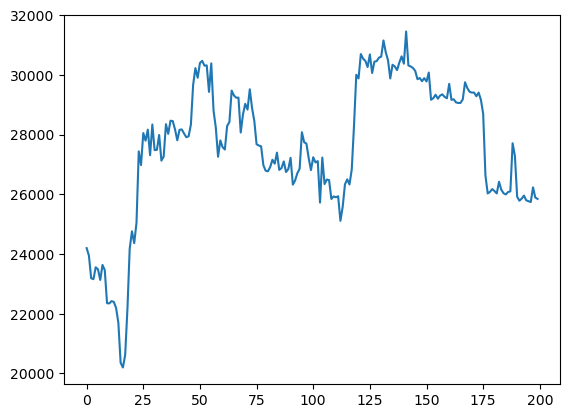

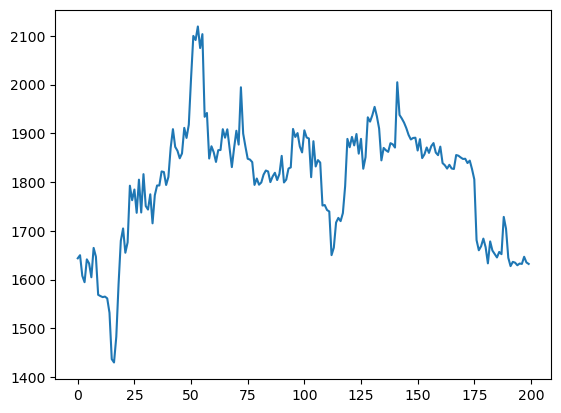

In [93]:
import pandas as pd
import numpy as np
from math import log
from scipy.stats import pearsonr
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def calculate_spread(closing_prices_asset_1, closing_prices_asset_2):
    if len(closing_prices_asset_1) != len(closing_prices_asset_2):
        raise ValueError("Input lists must have the same length")
    
    returns_asset_1 = np.diff(closing_prices_asset_1) / closing_prices_asset_1[:-1]
    returns_asset_2 = np.diff(closing_prices_asset_2) / closing_prices_asset_2[:-1]

    spread = [a - b for a, b in zip(returns_asset_1, returns_asset_2)]

    return spread

def calculate_zscore(spread):
    mean_spread = np.mean(spread)
    std_dev_spread = np.std(spread)
    z_scores = [(x - mean_spread) / std_dev_spread for x in spread]
    
    return z_scores

def hedge_ratio(closing_prices_asset_2, closing_prices_asset_1):
    closing_prices_asset_1 = sm.add_constant(closing_prices_asset_1)
    model = sm.OLS(closing_prices_asset_2, closing_prices_asset_1).fit()
    return model.params[1]

df_1 = pd.read_csv("../../data/btc_usd.csv")
df_2 = pd.read_csv("../../data/eth_usd.csv")
asset_1 = pd.DataFrame(df_1)
asset_2 = pd.DataFrame(df_2)

closing_prices_asset_1 = asset_1["close"]
closing_prices_asset_2 = asset_2["close"]

spread = calculate_spread(closing_prices_asset_1, closing_prices_asset_2)

zscore = calculate_zscore(spread)

pyplot.plot(closing_prices_asset_1)
pyplot.show()
pyplot.plot(closing_prices_asset_2)
pyplot.show()

In [108]:
closing_prices_asset_1 = closing_prices_asset_1[:199]
closing_prices_asset_2 = closing_prices_asset_2[:199]

# Convert zscore to a NumPy array or pandas Series
zscore = np.array(zscore)  # Convert to NumPy array

# Initialize positions and signals
positions_asset_1 = np.zeros_like(zscore)
positions_asset_2 = np.zeros_like(zscore)
signals = np.zeros_like(zscore)

# Initialize variables for trade simulation
capital = 1000000  # Initial capital in USD
volume_per_trade = 0.01  # Volume per trade in BTC or ETH (adjust as needed)
position_asset_1 = 0
position_asset_2 = 0
total_profit = 0

# Entry and exit signals based on zscore
entry_threshold = 2.5
exit_threshold = -2.5

trades = []

for i in range(1, len(zscore)):
    if zscore[i] >= entry_threshold and zscore[i - 1] < entry_threshold:
        # Long asset_2 and short asset_1
        positions_asset_1[i] = -1
        positions_asset_2[i] = 1
        signals[i] = 1  # Entry signal

        # Calculate entry prices for this trade
        entry_price_asset_1 = closing_prices_asset_1[i]
        entry_price_asset_2 = closing_prices_asset_2[i]

    elif zscore[i] <= exit_threshold and zscore[i - 1] > exit_threshold:
        # Long asset_1 and short asset_2
        positions_asset_1[i] = 1
        positions_asset_2[i] = -1
        signals[i] = -1  # Exit signal

        # Calculate exit prices for this trade
        exit_price_asset_1 = closing_prices_asset_1[i]
        exit_price_asset_2 = closing_prices_asset_2[i]

        # Create a new trade with specific entry and exit prices
        trade = {
            "entry_date": asset_1.index[i],
            "entry_price_asset_1": entry_price_asset_1,
            "entry_price_asset_2": entry_price_asset_2,
            "exit_date": asset_1.index[i],
            "exit_price_asset_1": exit_price_asset_1,
            "exit_price_asset_2": exit_price_asset_2,
            "volume_asset_1": -position_asset_1 * volume_per_trade,
            "volume_asset_2": position_asset_2 * volume_per_trade,
        }

        # Execute the trade by updating positions and capital
        position_asset_1 += trade["volume_asset_1"]
        position_asset_2 += trade["volume_asset_2"]
        capital += trade["volume_asset_1"] * trade["entry_price_asset_1"] + trade["volume_asset_2"] * trade["entry_price_asset_2"]

        # Calculate profit for the trade and update total profit
        trade_profit = (trade["volume_asset_1"] * (trade["exit_price_asset_1"] - trade["entry_price_asset_1"]) +
                        trade["volume_asset_2"] * (trade["entry_price_asset_2"] - trade["exit_price_asset_2"]))
        total_profit += trade_profit

        # Update profit information within the trade dictionary
        trade["profit"] = trade_profit
        trade["capital"] = capital

        # Add the trade to the list of trades
        trades.append(trade)

# Create a DataFrame with trade details
trades_df = pd.DataFrame(trades)

# Print the trade details
print(trades_df)

   entry_date  entry_price_asset_1  entry_price_asset_2  ...  volume_asset_2  \
0          49              22154.4              1589.99  ...             0.0   
1          71              22154.4              1589.99  ...             0.0   
2         127              22154.4              1589.99  ...             0.0   
3         140              22154.4              1589.99  ...             0.0   

   profit    capital  
0     0.0  1000000.0  
1    -0.0  1000000.0  
2    -0.0  1000000.0  
3    -0.0  1000000.0  

[4 rows x 10 columns]


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo


In [103]:
# Create a DataFrame with trade details
trades_df = pd.DataFrame(trades)

# Create Plotly trace for closing prices
trace_closing_price_asset_2 = go.Scatter(
    x=closing_prices_asset_2.index,
    y=closing_prices_asset_2.values,
    mode='lines',
    name='Closing Price Asset 2'
)

# Create Plotly trace for entry prices
trace_entry_price_asset_2 = go.Scatter(
    x=trades_df['entry_date'],
    y=trades_df['entry_price_asset_2'],
    mode='markers',
    marker=dict(symbol='triangle-up', size=8, color='green'),
    name='Entry Price Asset 2'
)

# Create Plotly trace for exit prices
trace_exit_price_asset_2 = go.Scatter(
    x=trades_df['exit_date'],
    y=trades_df['exit_price_asset_2'],
    mode='markers',
    marker=dict(symbol='triangle-down', size=8, color='red'),
    name='Exit Price Asset 2'
)

# Create a Plotly layout
layout = go.Layout(
    title='Entry and Closing Prices on Asset 2',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    showlegend=True
)


# Create a Plotly figure
fig = go.Figure(data=[trace_closing_price_asset_2, trace_entry_price_asset_2, trace_exit_price_asset_2], layout=layout)

# Display the plot
pyo.iplot(fig)